## Explanation Analysis Germany
This Notebook is designed to generate the explanations for the origins of uncertainty for the German data set

In [1]:
import numpy as np
import pandas as pd
import torch
import sys
import os

sys.path.append("..")
from pipelines.preprocessing_pipeline import prep_data_temporal
from models.gaussian_history_only_network import GaussianHistoryNetwork, create_gaussian_history_predictions
from metrics.crps import calculate_crps_gaussian
from metrics.evaluation_functions_real_history import create_prediction_plot, gaussian_explaination_plot_sample, create_stacked_explainations, plot_mean_specific_time
import tomlkit

In [22]:
df = pd.read_csv("../data/de.csv", index_col="start", parse_dates=True)
df = df.drop(columns='end')
df.index.name = "time"
df = df.resample('H').sum()

In [23]:
with open('../configs/germany_config.toml', 'rb') as f:
    configs = tomlkit.load(f)

### Select Config and load models
The first step is to select the configuration we use and to load the appropriate models that have already been trained

In [24]:
# Select config to use
config = configs['Config1']

In [25]:
history_length = config['history_length']
forecast_horizon = config['forecast_horizon']
learning_rate = config['learning_rate']
number_epochs = config['number_epochs']
batch_size = config['batch_size']
hidden_size_history_network = config['hidden_size_history_network']
hidden_size_temporal_network = config['hidden_size_temporal_network']
hidden_size_history_encoder_temporal_network = config['hidden_size_history_encoder_temporal_network']
test_size = config['test_size']
save_path = config['save_path']
save_name_history = config['save_name_history']
save_name_temporal = config['save_name_temporal']
target_var = config['target_var']
descriptor = config['descriptor']

In [26]:
target_train, target_test, history_train, history_test, hour_cos_train, hour_cos_test, hour_sin_train, \
    hour_sin_test, day_cos_train, day_cos_test, day_sin_train, day_sin_test, month_cos_train, month_cos_test, \
    month_sin_train, month_sin_test, target_scaler, history_scaler = prep_data_temporal(df=df,
                                                                                        target_var=target_var,
                                                                                        history_length=history_length,
                                                                                        forecast_horizon=forecast_horizon,
                                                                                        test_size=test_size)

In [27]:
# Create model only using historical values
history_model = GaussianHistoryNetwork(input_size=history_length,
                                       hidden_size=hidden_size_history_network,
                                       output_size=forecast_horizon)
history_model.load_state_dict(torch.load(f"../{save_path}/models/{descriptor}_{save_name_history}"))

<All keys matched successfully>

In [28]:
mu_test_history, logvar_test_history = create_gaussian_history_predictions(model=history_model,
                                                                           X_test=history_test)

### Calculate CRPS and plot predictions
The next step is to calculate the CRPS and plot some prediction intervals

In [29]:
#History
calculate_crps_gaussian(target_test, mu_test_history, logvar_test_history)

0.15481707

In [30]:
plot_history = create_prediction_plot(start=168+8+72-24,
                                      num=2,
                                      fh=int(forecast_horizon),
                                      target=target_test,
                                      mu=mu_test_history,
                                      logvar=logvar_test_history,
                                      scaler=target_scaler,
                                      name=f"Figures/germany/Germany{history_length}.tex")

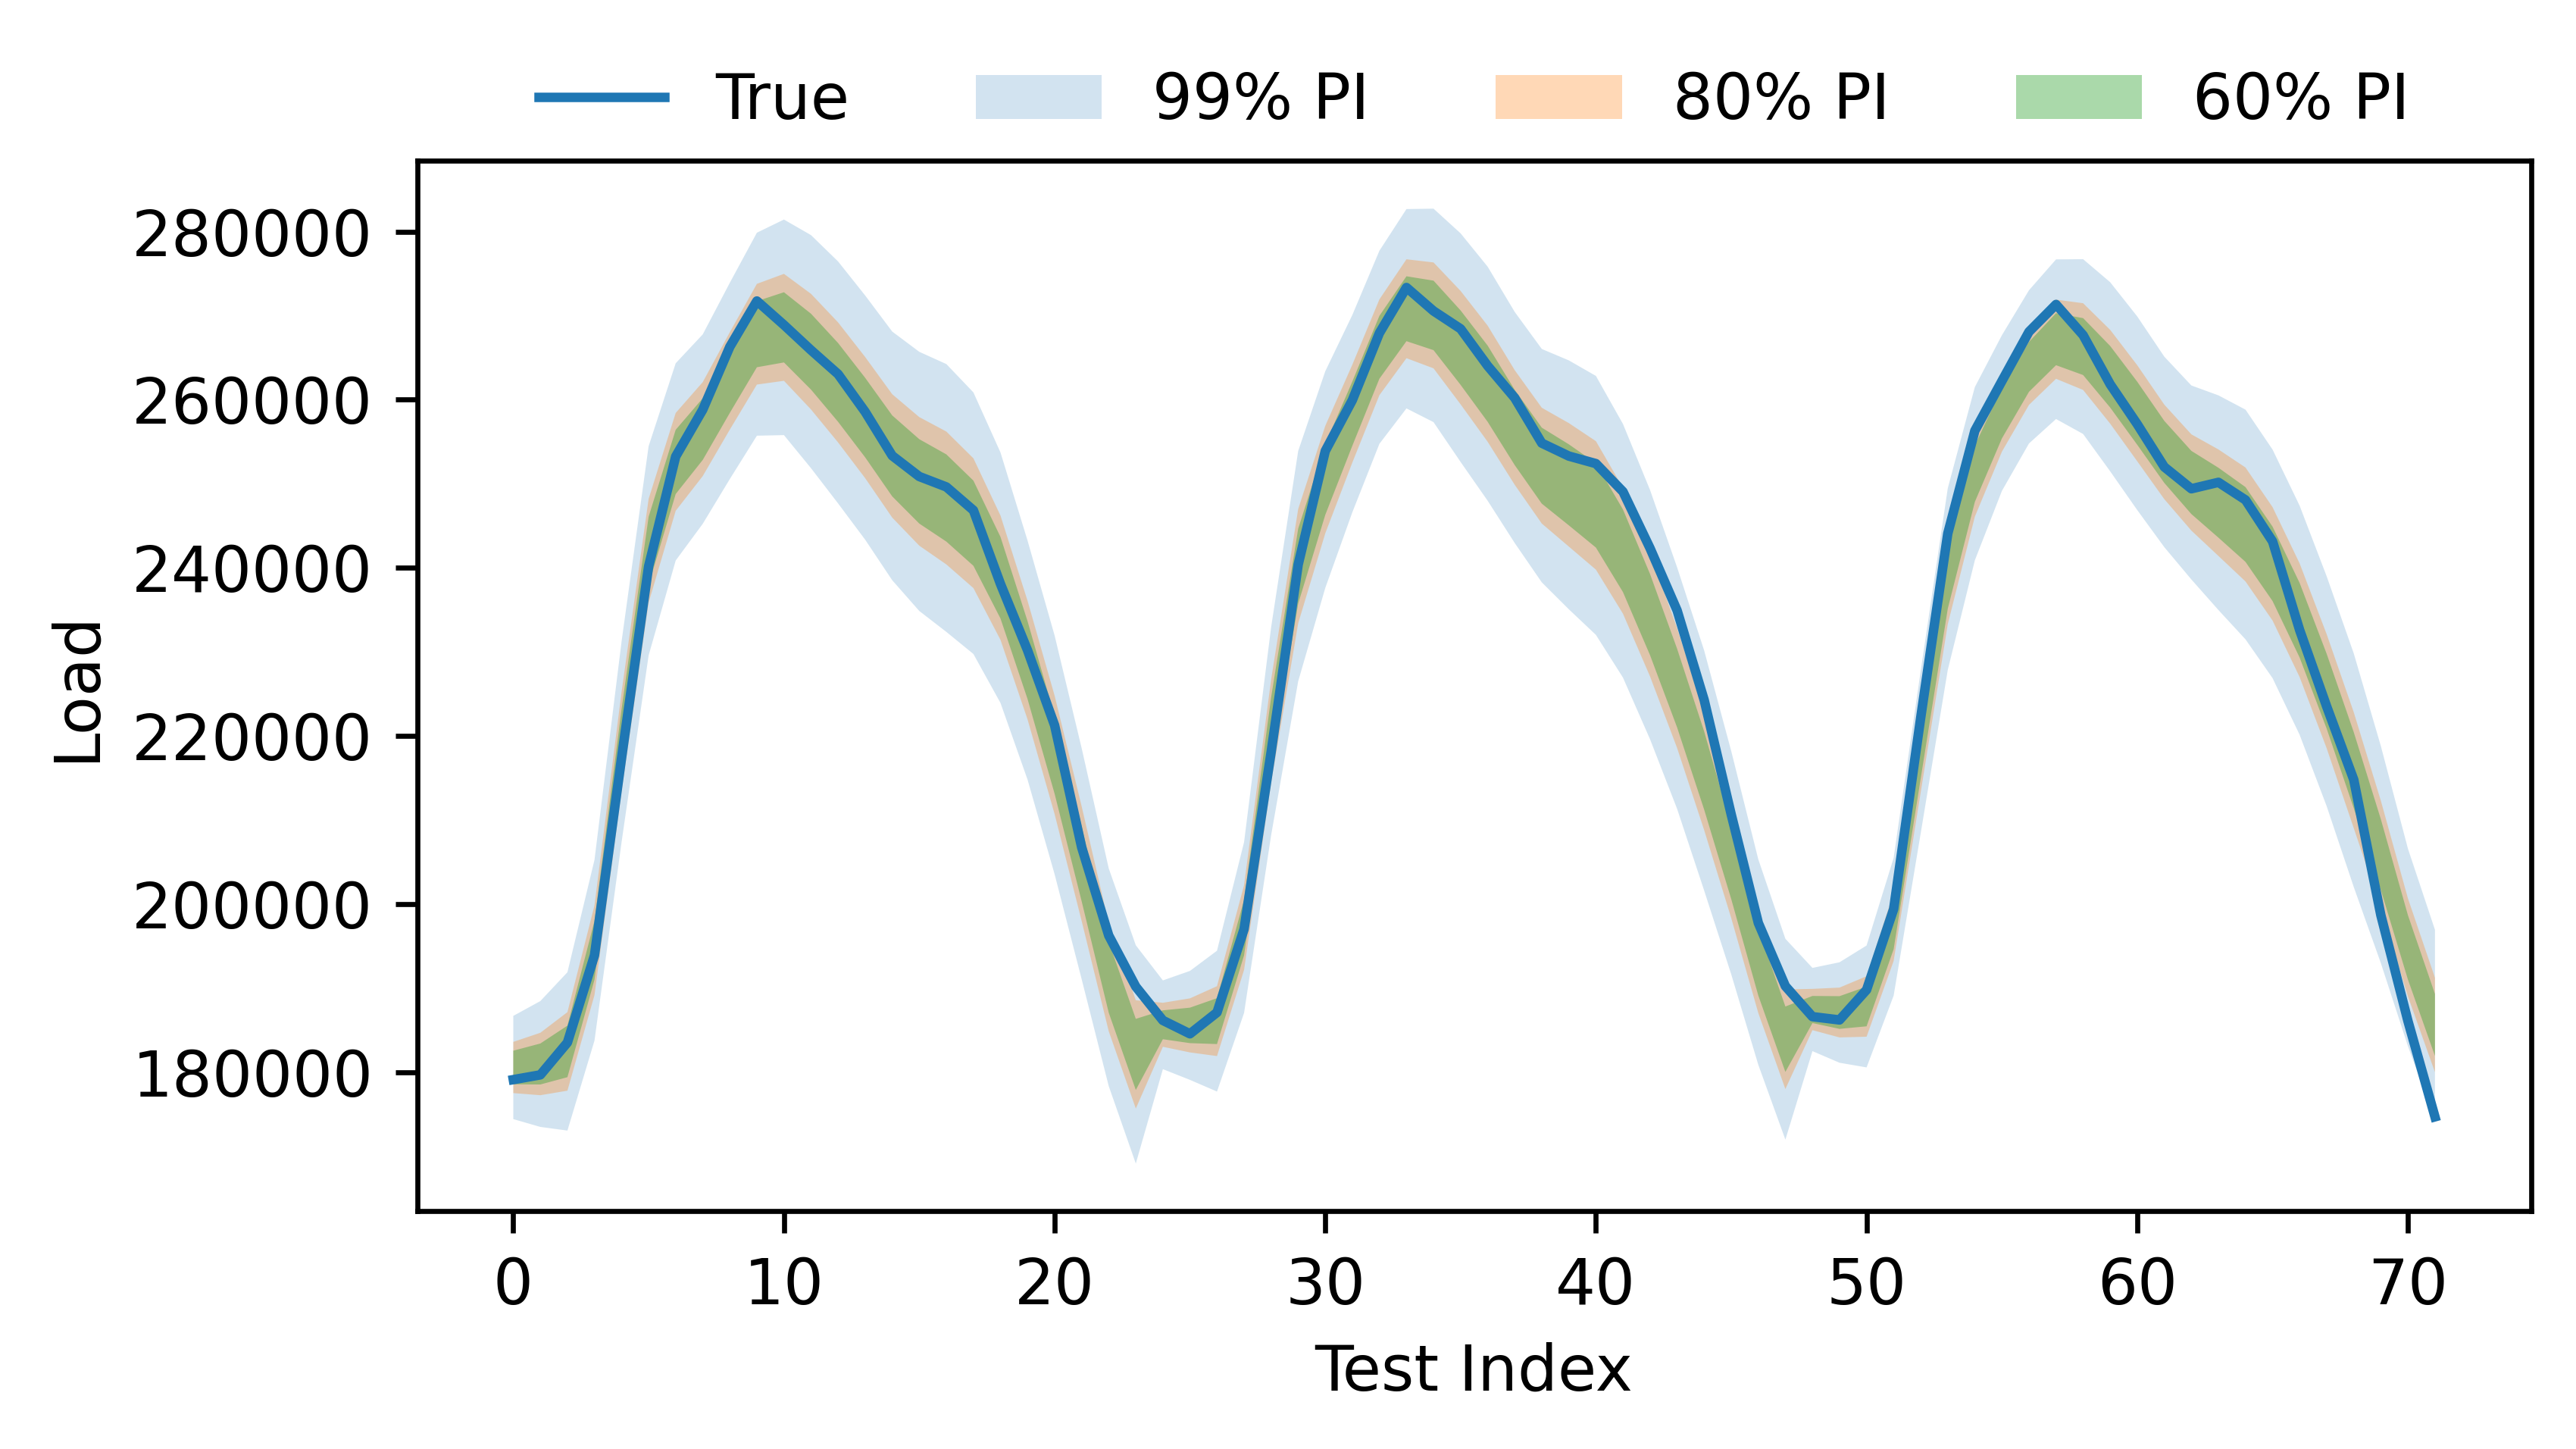

In [31]:
plot_history

## Create and Investigate Attributions
Now we create and investigate the attributions

In [5]:
day_start_offset = 8+168*2
all_indexes = np.arange(day_start_offset, len(history_test), 1)
if history_length == 168:
    day_name_map = dict({0: "Tuesday", 1: "Wednesday", 2: "Thursday",
                     3: "Friday", 4: "Saturday", 5: "Sunday",
                     6: "Monday"})
elif history_length == 48:
    day_name_map = dict({0: "Monday", 1: "Tuesday", 2: "Wednesday",
                     3: "Thursday", 4: "Friday", 5: "Saturday",
                     6: "Sunday"})
# Consider Weekly Patterns
step = 168
save_loc = "Figures/germany/"
isExist = os.path.exists(save_loc)
if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(save_loc)

In [ ]:
sample_plot = dict()
for key, item in day_name_map.items():
    sample_plot[day_name_map[key]] = gaussian_explaination_plot_sample(model=history_model,
                                                                       sample=day_start_offset + int(key)*24,
                                                                       fh=forecast_horizon,
                                                                       history=history_test,
                                                                       hl=history_length,
                                                                       scaler=history_scaler)

In [34]:
stacked_explain = create_stacked_explainations(model=history_model,
                                               indexes=np.arange(day_start_offset,len(history_test),1),
                                               fh=forecast_horizon,
                                               history=history_test)

In [ ]:
mean_plot_dict = dict()
for key, item in day_name_map.items():
    mean_plot_dict[day_name_map[key]] = plot_mean_specific_time(stacked_explainer_dict=stacked_explain,
                                    indexes=np.arange(day_start_offset,len(history_test),1),
                                    history=history_test,
                                    step=step,
                                    start=int(key) * 24,
                                    scaler=history_scaler,
                                    fh=forecast_horizon,
                                    hl=history_length)

In [37]:
for key,item in day_name_map.items():
    sample_plot[day_name_map[key]].savefig(f"{save_loc}{history_length}_Single_Sample_{day_name_map[key]}.pdf", format="pdf", bbox_inches="tight")
    mean_plot_dict[day_name_map[key]].savefig(f"{save_loc}{history_length}_Mean_{day_name_map[key]}.pdf", format="pdf", bbox_inches="tight")